# GAN with Hyperparameter Tuning
In this notebook, I have trained a GAN with various hyperparameters, activation functions, and optimizers. I have also calculated precision and recall to evaluate the model's performance.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import numpy as np

## Defining the Generator and Discriminator Models

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim, activation_function=nn.ReLU):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            activation_function(),
            nn.Linear(128, 256),
            activation_function(),
            nn.Linear(256, 512),
            activation_function(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.model(noise)


In [3]:
class Discriminator(nn.Module):
    def __init__(self, activation_function=nn.LeakyReLU):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            activation_function(0.2),
            nn.Linear(512, 256),
            activation_function(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.model(image)

## Hyperparameters and Dataset Preparation

In [4]:
noise_dim = 100
batch_size = 64
num_epochs = 20
learning_rates = [0.0002, 0.0001]
activation_functions = [nn.ReLU, nn.ELU, nn.SELU]
optimizers = [optim.Adam, optim.SGD]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Function to Train and Evaluate GAN

In [5]:
def train_and_evaluate_gan(activation_function, optimizer_type, learning_rate):
    generator = Generator(noise_dim, activation_function)
    discriminator = Discriminator(activation_function)

    loss_function = nn.BCELoss()

    gen_optimizer = optimizer_type(generator.parameters(), lr=learning_rate)
    disc_optimizer = optimizer_type(discriminator.parameters(), lr=learning_rate)

    generator_losses = []
    discriminator_losses = []
    precisions = []
    recalls = []

    for epoch in range(num_epochs):
        for real_images, _ in dataloader:
            real_images = real_images.view(real_images.size(0), -1)
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            noise = torch.randn(batch_size, noise_dim)
            fake_images = generator(noise)

            disc_optimizer.zero_grad()
            real_output = discriminator(real_images)
            fake_output = discriminator(fake_images.detach())
            real_loss = loss_function(real_output, real_labels)
            fake_loss = loss_function(fake_output, fake_labels)
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            disc_optimizer.step()

            gen_optimizer.zero_grad()
            fake_output_for_gen = discriminator(fake_images)
            gen_loss = loss_function(fake_output_for_gen, real_labels)
            gen_loss.backward()
            gen_optimizer.step()

        generator_losses.append(gen_loss.item())
        discriminator_losses.append(disc_loss.item())

        all_labels = torch.cat((real_labels, fake_labels), dim=0).detach().numpy()
        all_preds = torch.cat((real_output, fake_output), dim=0).detach().round().numpy()
        precisions.append(precision_score(all_labels, all_preds))
        recalls.append(recall_score(all_labels, all_preds))

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"D Loss: {disc_loss:.4f} | G Loss: {gen_loss:.4f} | "
              f"Precision: {precisions[-1]:.4f} | Recall: {recalls[-1]:.4f}")

    return generator_losses, discriminator_losses, precisions, recalls

## Running Experiments

In [6]:
results = {}
for activation in activation_functions:
    for optimizer in optimizers:
        for lr in learning_rates:
            print(f"Training with Activation: {activation.__name__}, Optimizer: {optimizer.__name__}, LR: {lr}")
            gen_losses, disc_losses, precisions, recalls = train_and_evaluate_gan(activation, optimizer, lr)
            key = f"{activation.__name__}_{optimizer.__name__}_LR{lr}"
            results[key] = {
                "gen_losses": gen_losses,
                "disc_losses": disc_losses,
                "precisions": precisions,
                "recalls": recalls
            }

Training with Activation: ReLU, Optimizer: Adam, LR: 0.0002
Epoch [1/20] | D Loss: 0.4189 | G Loss: 2.5823 | Precision: 1.0000 | Recall: 0.9062
Epoch [2/20] | D Loss: 0.6672 | G Loss: 2.3180 | Precision: 1.0000 | Recall: 0.7812
Epoch [3/20] | D Loss: 0.4422 | G Loss: 3.2299 | Precision: 0.9333 | Recall: 0.8750
Epoch [4/20] | D Loss: 0.8606 | G Loss: 1.3944 | Precision: 0.8485 | Recall: 0.8750
Epoch [5/20] | D Loss: 0.2851 | G Loss: 2.7683 | Precision: 1.0000 | Recall: 0.9688
Epoch [6/20] | D Loss: 0.3483 | G Loss: 4.6085 | Precision: 1.0000 | Recall: 0.9062
Epoch [7/20] | D Loss: 0.2074 | G Loss: 4.2561 | Precision: 1.0000 | Recall: 0.9688
Epoch [8/20] | D Loss: 0.1419 | G Loss: 3.4000 | Precision: 1.0000 | Recall: 0.9688
Epoch [9/20] | D Loss: 0.3294 | G Loss: 5.6050 | Precision: 1.0000 | Recall: 0.8750
Epoch [10/20] | D Loss: 0.8141 | G Loss: 3.6517 | Precision: 0.8235 | Recall: 0.8750
Epoch [11/20] | D Loss: 0.3052 | G Loss: 3.3506 | Precision: 1.0000 | Recall: 0.9375
Epoch [12/20] 

## Plotting Results

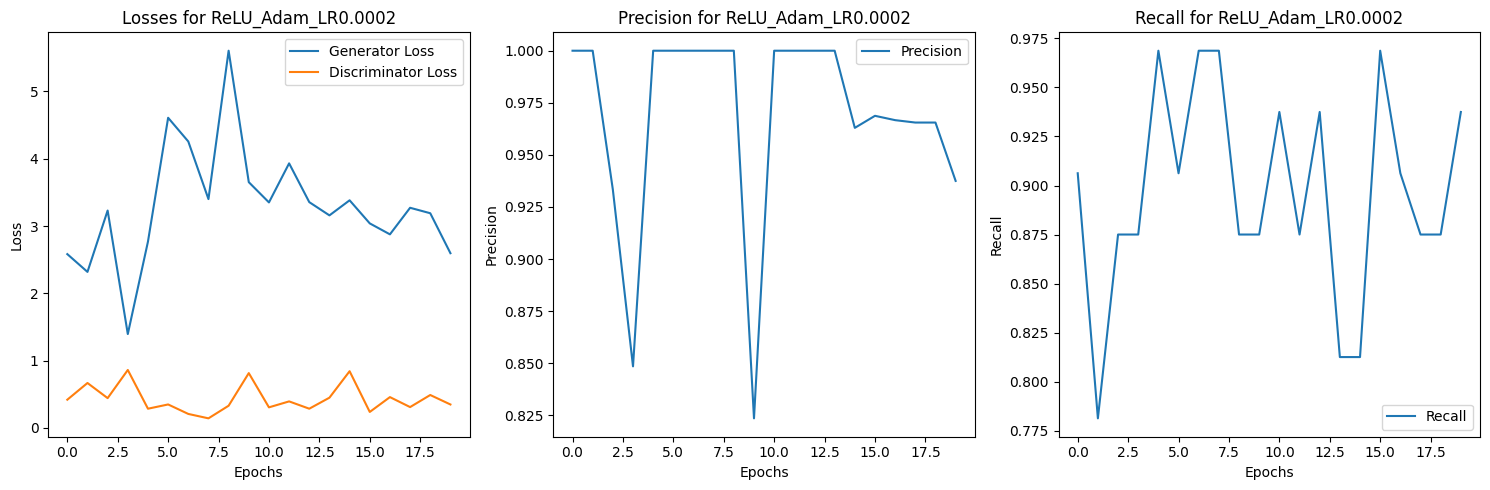

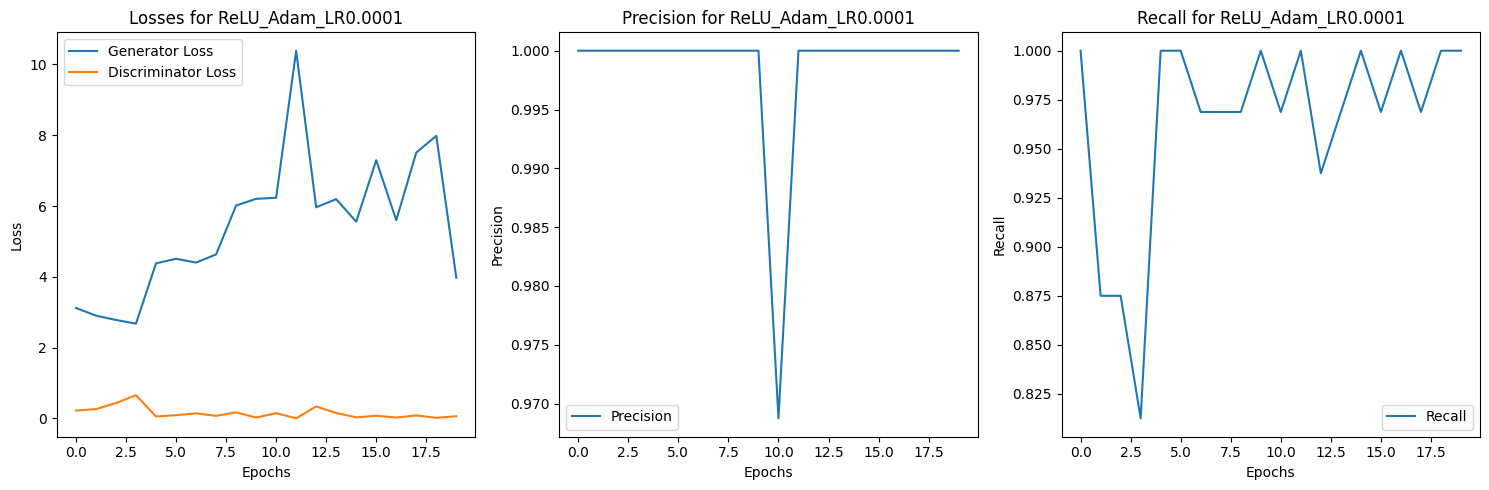

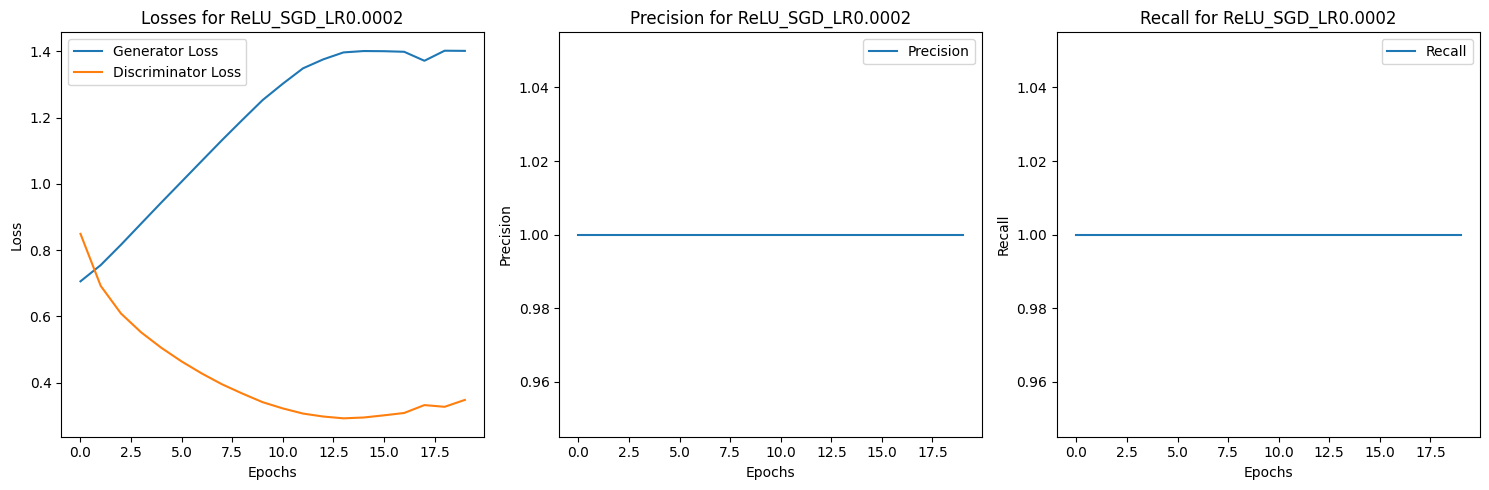

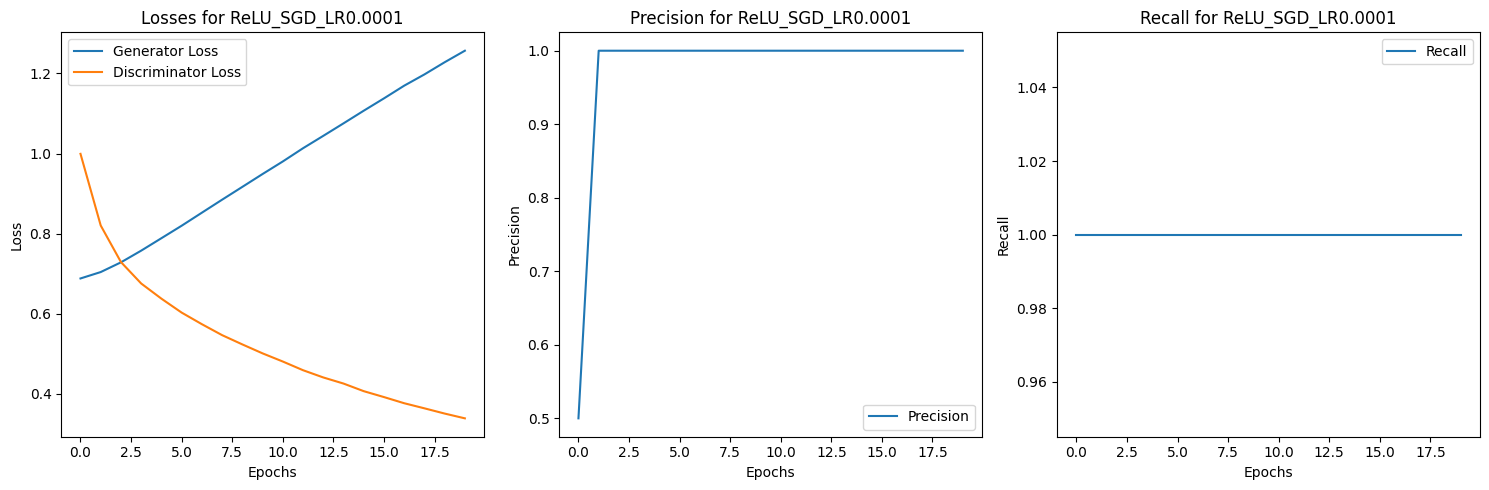

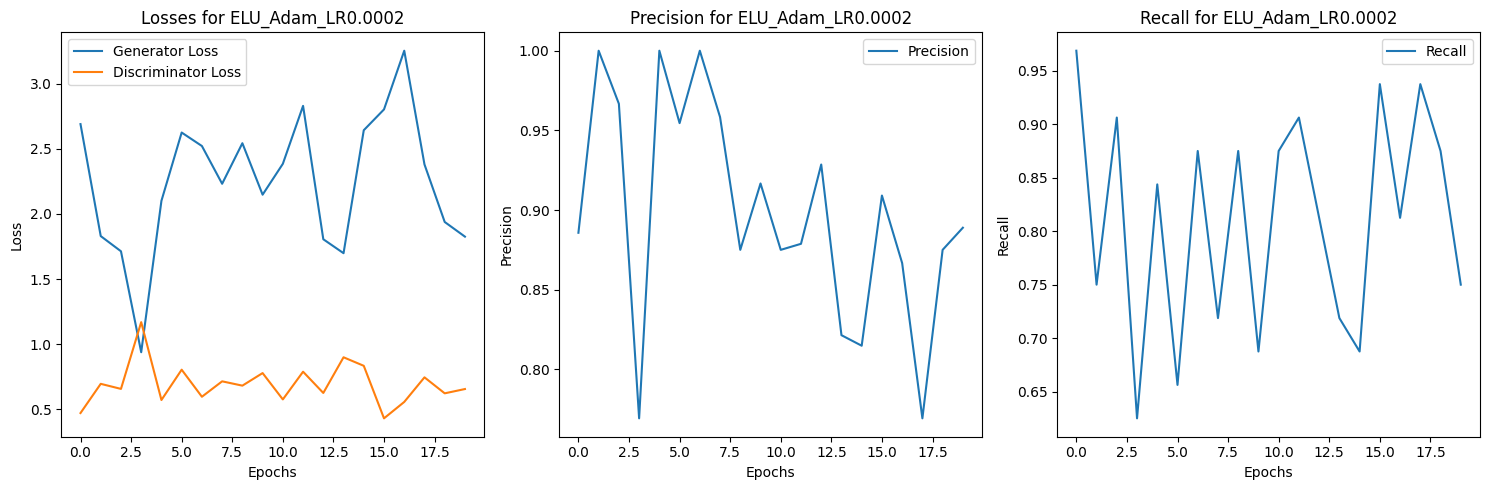

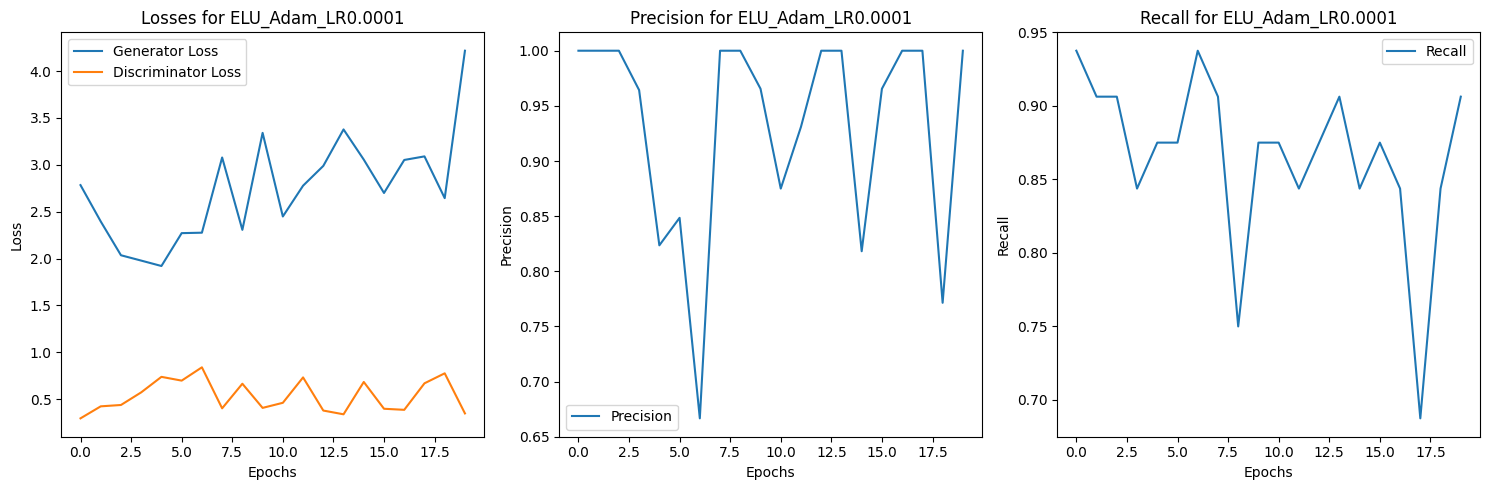

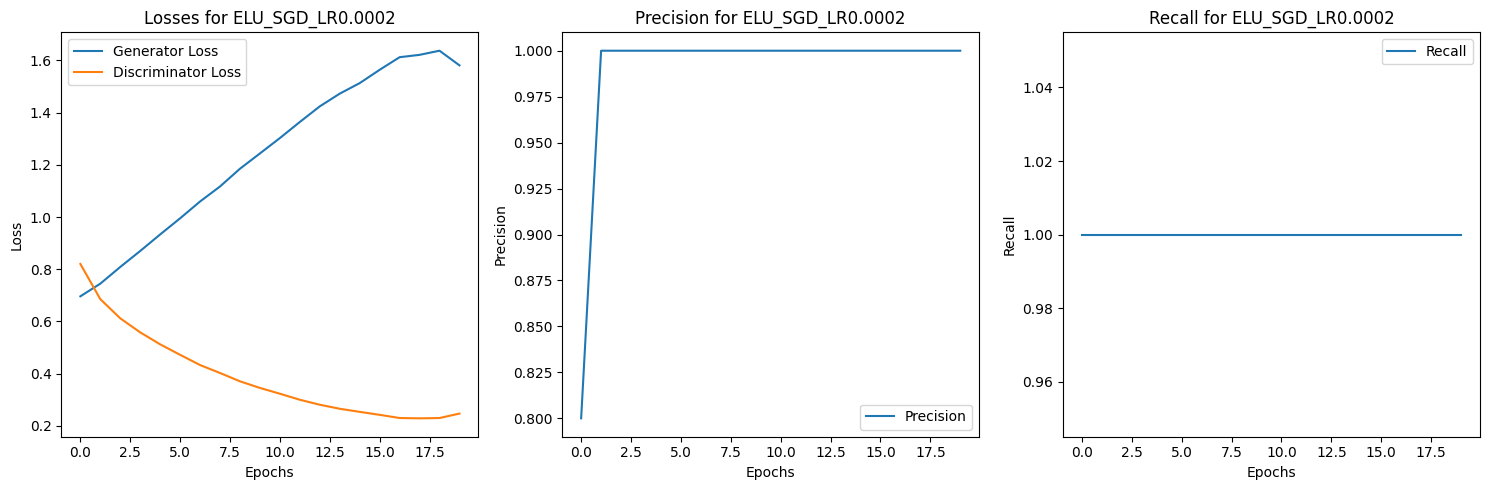

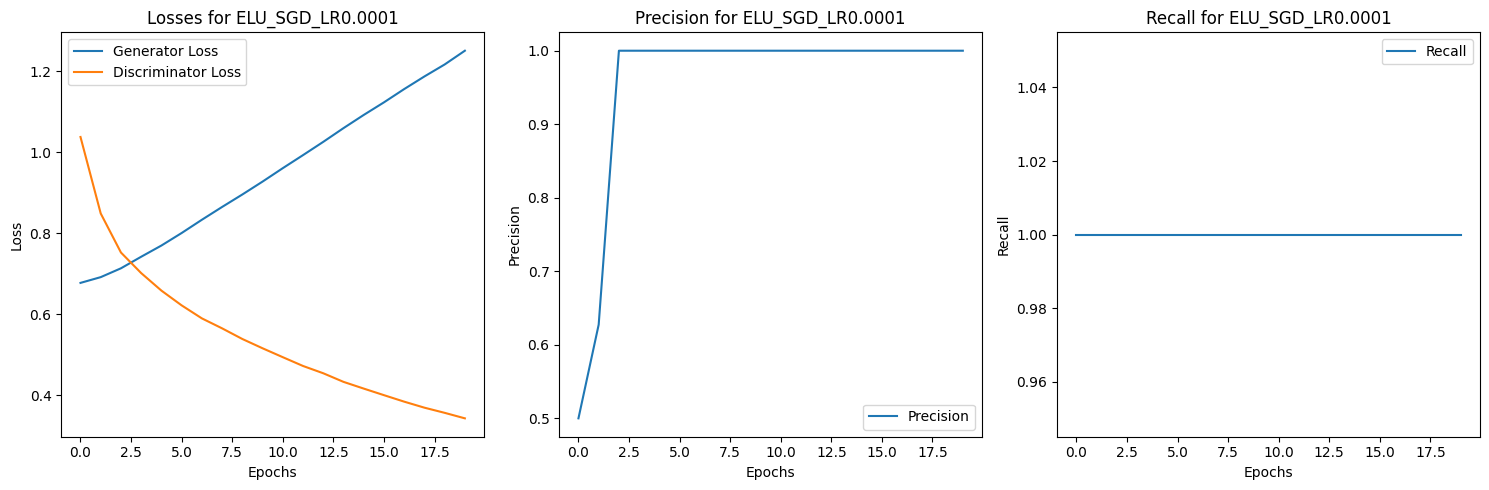

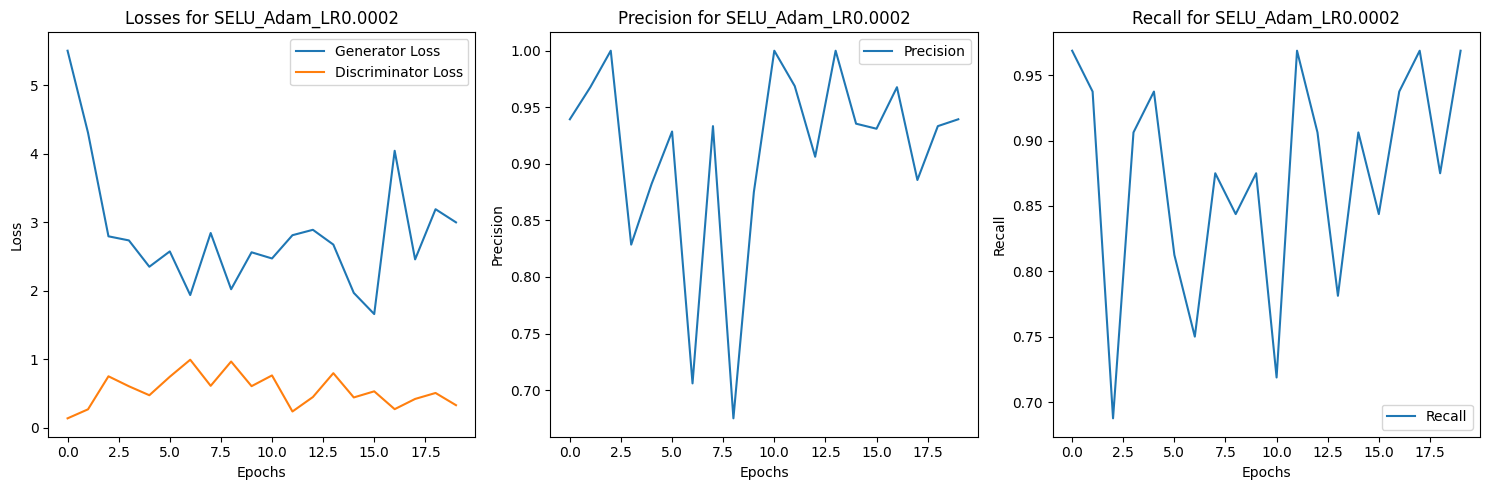

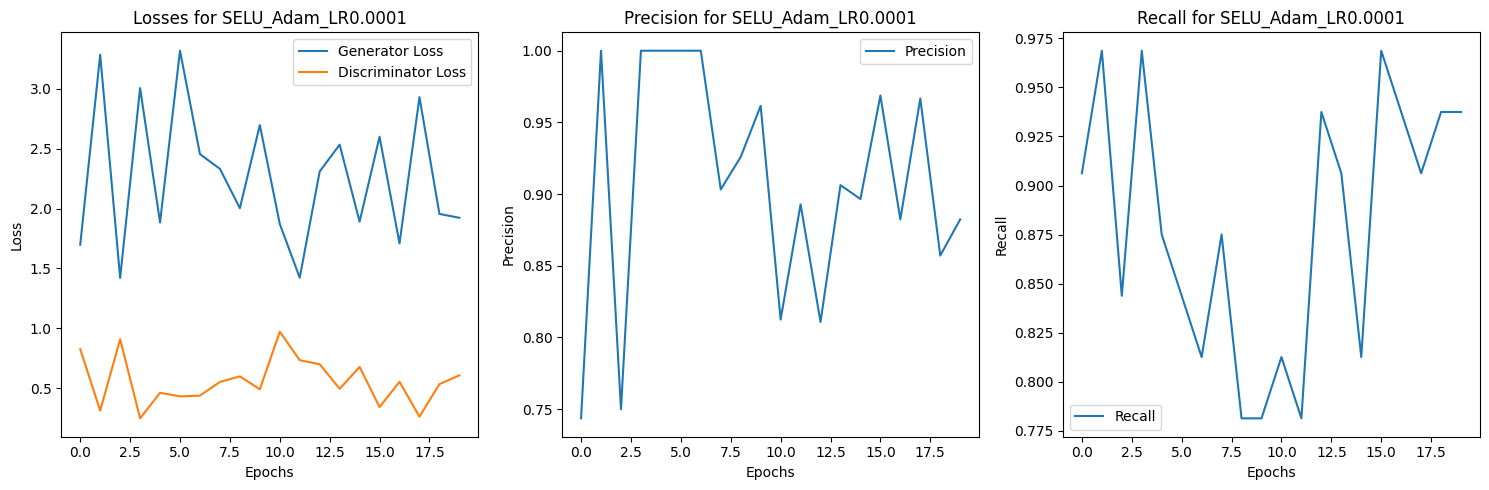

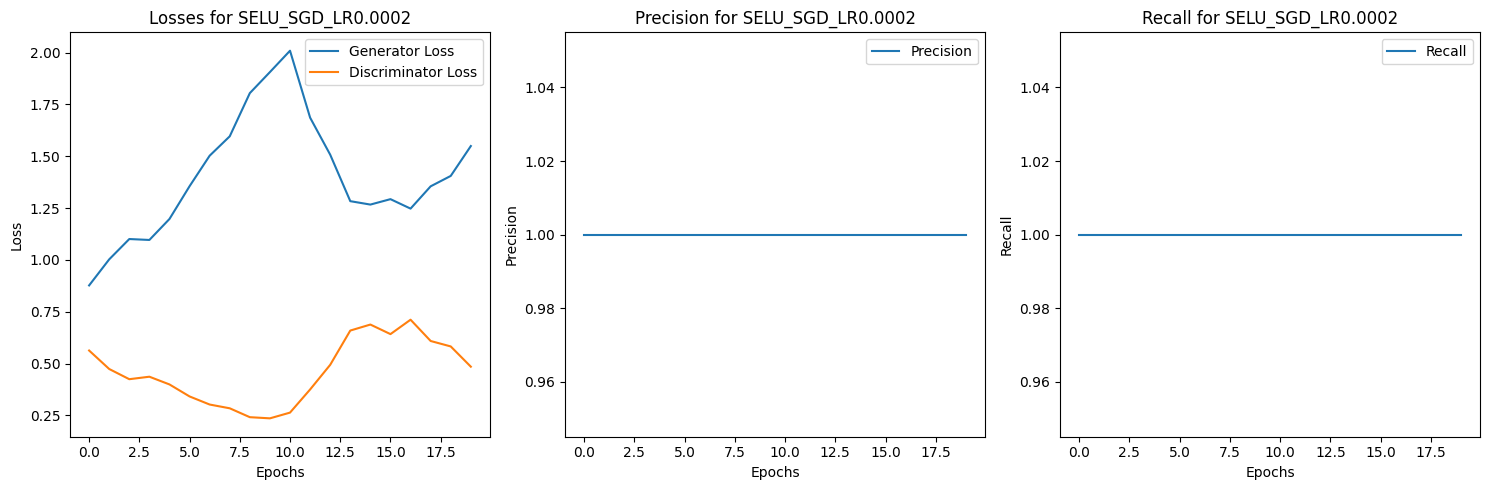

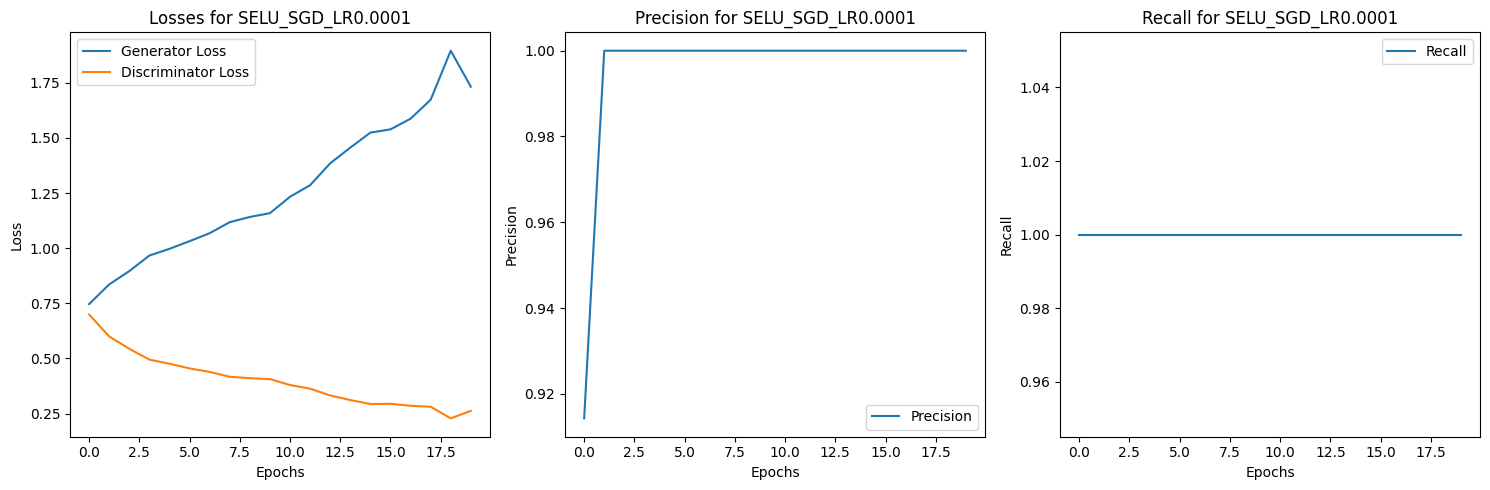

In [8]:
def plot_results(results):
    for key, values in results.items():
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(values["gen_losses"], label="Generator Loss")
        plt.plot(values["disc_losses"], label="Discriminator Loss")
        plt.title(f"Losses for {key}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(values["precisions"], label="Precision")
        plt.title(f"Precision for {key}")
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(values["recalls"], label="Recall")
        plt.title(f"Recall for {key}")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_results(results)

## Identifying the Best Configuration

In [9]:
best_config = max(results.items(), key=lambda x: np.mean(x[1]["precisions"]))
print(f"The best configuration is: {best_config[0]} with an average Precision of {np.mean(best_config[1]['precisions']):.4f}")

The best configuration is: ReLU_SGD_LR0.0002 with an average Precision of 1.0000
